In [1]:
#importing the required libraries
import json
import glob
import numpy as np
import sys
import cv2
import copy
import random
import pandas as pd
import os
import matplotlib.pyplot as plt
import face_recognition
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.nn import CrossEntropyLoss

In [2]:
#to load preprocessod videos
video_files  =  glob.glob('C:/Users/mehmoodyar.baig/Desktop/deepfake detection/dataset/cropped/Celeb_faces/*.mp4')
video_files += glob.glob('C:/Users/mehmoodyar.baig/Desktop/deepfake detection/dataset/cropped/DFDC_faces/*.mp4')
video_files += glob.glob('C:/Users/mehmoodyar.baig/Desktop/deepfake detection/dataset/cropped/FF_faces/*.mp4')

random.shuffle(video_files)
random.shuffle(video_files)
frame_count = []
for video_file in video_files:
    cap = cv2.VideoCapture(video_file)
    if(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))<100):    
        video_files.remove(video_file)
        continue
    frame_count.append(int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
print("frames are " , frame_count[:5])
print("Total no of video: " , len(frame_count))
print('Average frame per video:',np.mean(frame_count))

frames are  [148, 148, 148, 148, 148]
Total no of video:  6404
Average frame per video: 147.79684572142412


In [3]:
# load the video name and labels from csv
class video_dataset(Dataset):
    def __init__(self,video_names,labels,sequence_length = 60,transform = None):
        self.video_names = video_names
        self.labels = labels
        self.transform = transform
        self.count = sequence_length
    def __len__(self):
        return len(self.video_names)
    def __getitem__(self,idx):
        video_path = self.video_names[idx]
        frames = []
        a = int(100/self.count)
        first_frame = np.random.randint(0,a)
        #print(video_path)
        temp_video = video_path.split(os.sep)[-1]
        print(temp_video)
        label = self.labels.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        if(label == 'FAKE'):
            label = 0
        if(label == 'REAL'):
            label = 1
        for i,frame in enumerate(self.frame_extract(video_path)):
            frames.append(self.transform(frame))
            if(len(frames) == self.count):
                break
        frames = torch.stack(frames)
        frames = frames[:self.count]
        print("length:" , len(frames), "label",label)
        return frames,label
    def frame_extract(self,path):
        vidObj = cv2.VideoCapture(path)
        success = 1
        while success:
            success, image = vidObj.read()
            if success:
                yield image

#plot the image
def im_plot(tensor):
    image = tensor.cpu().numpy().transpose(1,2,0)
    b,g,r = cv2.split(image)
    image = cv2.merge((r,g,b))
    image = image*[0.22803, 0.22145, 0.216989] +  [0.43216, 0.394666, 0.37645]
    image = image*255.0
    plt.imshow(image.astype(int))
    plt.show()

In [4]:
#count the number of fake and real videos in dataset
def number_of_real_and_fake_videos(data_list):
    header_list = ["file","label"]
    lab = pd.read_csv('C:/Users/mehmoodyar.baig/Desktop/deepfake detection/labels/Gobal_metadata.csv',names=header_list)
    fake = 0
    real = 0
    for i in data_list:
        temp_video = i.split(os.sep)[-1]
        #print(temp_video)
        label = lab.iloc[(labels.loc[labels["file"] == temp_video].index.values[0]),1]
        #print(label)
        if(label == 'FAKE'):
            fake+=1
        if(label == 'REAL'):
            real+=1
    return real,fake

train :  5141
test :  1286
TRAIN:  Real: 2638  Fake: 2503
TEST:  Real: 663  Fake: 623
cxobtfqqqo.mp4
length: 10 label 1


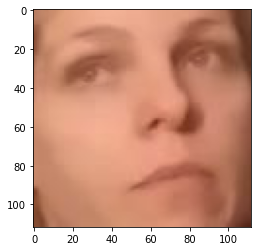

In [5]:
# load the labels and video in data loader
header_list = ["file","label"]
labels = pd.read_csv('C:/Users/mehmoodyar.baig/Desktop/deepfake detection/labels/Gobal_metadata.csv', names=header_list)
#print(labels)
train_videos = video_files[:int(0.8*len(video_files))]
valid_videos = video_files[int(0.8*len(video_files)):]
print("train : " , len(train_videos))
print("test : " , len(valid_videos))
print("TRAIN: ", "Real:",number_of_real_and_fake_videos(train_videos)[0]," Fake:",number_of_real_and_fake_videos(train_videos)[1])
print("TEST: ", "Real:",number_of_real_and_fake_videos(valid_videos)[0]," Fake:",number_of_real_and_fake_videos(valid_videos)[1])


im_size = 112
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])

test_transforms = transforms.Compose([
                                        transforms.ToPILImage(),
                                        transforms.Resize((im_size,im_size)),
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean,std)])
train_data = video_dataset(train_videos,labels,sequence_length = 10,transform = train_transforms)
#print(train_data)
val_data = video_dataset(valid_videos,labels,sequence_length = 10,transform = train_transforms)
train_loader = DataLoader(train_data,batch_size = 4,shuffle = True,num_workers = 4)
valid_loader = DataLoader(val_data,batch_size = 4,shuffle = True,num_workers = 4)
image,label = train_data[0]
im_plot(image[0,:,:,:])




In [6]:
#Model with feature visualization
from torch import nn
from torchvision import models
class Model(nn.Module):
    def __init__(self, num_classes,latent_dim= 2048, lstm_layers=1 , hidden_dim = 2048, bidirectional = False):
        super(Model, self).__init__()
        model = models.resnext50_32x4d(pretrained = True) #Residual Network CNN
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.lstm = nn.LSTM(latent_dim,hidden_dim, lstm_layers,  bidirectional)
        self.relu = nn.LeakyReLU()
        self.dp = nn.Dropout(0.4)
        self.linear1 = nn.Linear(2048,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
    def forward(self, x):
        batch_size,seq_length, c, h, w = x.shape
        x = x.view(batch_size * seq_length, c, h, w)
        fmap = self.model(x)
        x = self.avgpool(fmap)
        x = x.view(batch_size,seq_length,2048)
        x_lstm,_ = self.lstm(x,None)
        logits = fmap, self.dp(self.linear1(torch.mean(x_lstm,dim = 1)))
        return logits

In [7]:
model = Model(2).cuda()
a,b = model(torch.from_numpy(np.empty((1,20,3,112,112))).type(torch.cuda.FloatTensor))

In [9]:
from torchsummaryX import summary
summary(model, torch.zeros(10, 20, 3, 112, 112).type(torch.cuda.FloatTensor))

                                              Kernel Shape  \
Layer                                                        
0_model.Conv2d_0                             [3, 64, 7, 7]   
1_model.BatchNorm2d_1                                 [64]   
2_model.ReLU_2                                           -   
3_model.MaxPool2d_3                                      -   
4_model.4.0.Conv2d_conv1                   [64, 128, 1, 1]   
5_model.4.0.BatchNorm2d_bn1                          [128]   
6_model.4.0.ReLU_relu                                    -   
7_model.4.0.Conv2d_conv2                    [4, 128, 3, 3]   
8_model.4.0.BatchNorm2d_bn2                          [128]   
9_model.4.0.ReLU_relu                                    -   
10_model.4.0.Conv2d_conv3                 [128, 256, 1, 1]   
11_model.4.0.BatchNorm2d_bn3                         [256]   
12_model.4.0.downsample.Conv2d_0           [64, 256, 1, 1]   
13_model.4.0.downsample.BatchNorm2d_1                [256]   
14_model

159_dp                                           -  
------------------------------------------------------------------------------------------------------
                            Totals
Total params            56.538434M
Trainable params        56.538434M
Non-trainable params           0.0
Mult-Adds             1.141204288G


C:\Users\mehmoodyar.baig\Anaconda3\lib\site-packages\torchsummaryX\torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_model.Conv2d_0,"[3, 64, 7, 7]","[200, 64, 56, 56]",9408.0,29503488.0
1_model.BatchNorm2d_1,[64],"[200, 64, 56, 56]",128.0,64.0
2_model.ReLU_2,-,"[200, 64, 56, 56]",NaN,NaN
3_model.MaxPool2d_3,-,"[200, 64, 28, 28]",NaN,NaN
4_model.4.0.Conv2d_conv1,"[64, 128, 1, 1]","[200, 128, 28, 28]",8192.0,6422528.0
...,...,...,...,...
155_model.7.2.ReLU_relu,-,"[200, 2048, 4, 4]",NaN,NaN
156_avgpool,-,"[200, 2048, 1, 1]",NaN,NaN
157_lstm,-,"[10, 20, 2048]",33554432.0,33554432.0


In [10]:
#defining training epochs 
def train_epoch(epoch, num_epochs, data_loader, model, criterion, optimizer):
    print("Training")
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    for i, (inputs, targets) in enumerate(data_loader):
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        _,outputs = model(inputs)
        loss  = criterion(outputs,targets.type(torch.cuda.LongTensor))
        acc = calculate_accuracy(outputs, targets.type(torch.cuda.LongTensor))
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        sys.stdout.write (
                "\r[Epoch %d/%d] [Batch %d / %d] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    num_epochs,
                    i,
                    len(data_loader),
                    losses.avg,
                    accuracies.avg))
    torch.save(model.state_dict(),'/checkpoint.pt')
    return losses.avg,accuracies.avg
def test(epoch,model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(data_loader):
            if torch.cuda.is_available():
                targets = targets.cuda().type(torch.cuda.FloatTensor)
                inputs = inputs.cuda()
            _,outputs = model(inputs)
            loss = torch.mean(criterion(outputs, targets.type(torch.cuda.LongTensor)))
            acc = calculate_accuracy(outputs,targets.type(torch.cuda.LongTensor))
            _,p = torch.max(outputs,1) 
            true += (targets.type(torch.cuda.LongTensor)).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))
            sys.stdout.write(
                    "\r[Batch %d / %d]  [Loss: %f, Acc: %.2f%%]"
                    % (
                        i,
                        len(data_loader),
                        losses.avg,
                        accuracies.avg
                        )
                    )
        print('\nAccuracy {}'.format(accuracies.avg))
    return true,pred,losses.avg,accuracies.avg
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
def calculate_accuracy(outputs, targets):
    batch_size = targets.size(0)

    _, pred = outputs.topk(1, 1, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1))
    n_correct_elems = correct.float().sum().item()
    return 100* n_correct_elems / batch_size

In [11]:
import seaborn as sn
#Output confusion matrix
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    print('True positive = ', cm[0][0])
    print('False positive = ', cm[0][1])
    print('False negative = ', cm[1][0])
    print('True negative = ', cm[1][1])
    print('\n')
    df_cm = pd.DataFrame(cm, range(2), range(2))
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
    plt.ylabel('Actual label', size = 20)
    plt.xlabel('Predicted label', size = 20)
    plt.xticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.yticks(np.arange(2), ['Fake', 'Real'], size = 16)
    plt.ylim([2, 0])
    plt.show()
    calculated_acc = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+ cm[1][1])
    print("Calculated Accuracy",calculated_acc*100)

In [12]:
#plot loss and accuracy
def plot_accuracy(train_accuracy, test_accuracy, num_epochs):
  loss_train = train_accuracy
  loss_val = test_accuracy
  epochs = range(1, num_epcohs+1)
  plt.plot(epochs, loss_train, 'black', label = 'Training Accuracy')
  plt.plot(epochs, loss_val, 'red', label = 'Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy') 
  plt.legend(['Train','Valid'])
  plt.title('Training and  Validation Accuracy')
  plt.show()

def plot_accuracy(train_loss, test_loss, num_epochs):
  loss_train = train_loss_avg
  loss_val = test_loss_avg
  epochs = range(1, num_epcohs+1)
  plt.plot(epochs, loss_train, 'black', label = 'Training Accuracy')
  plt.plot(epochs, loss_val, 'red', label = 'Validation Accuracy')
  plt.xlabel('Epoch')
  plt.ylabel('Average Loss') 
  plt.legend(['Train','Valid'])
  plt.title('Training and  Validation LOss')
  plt.show()

In [ ]:
#learning rate
lr = 1e-2#0.001
#number of epochs 
num_epochs = 1

criterion = CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= lr,weight_decay = 1e-2)

train_loss_avg =[]
train_accuracy = []
test_loss_avg = []
test_accuracy = []
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,num_epochs,train_loader,model,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    true,pred,tl,t_acc = test(epoch,model,valid_loader,criterion)
    test_loss_avg.append(tl)
    test_accuracy.append(t_acc)
print(epoch)

Training


In [ ]:
#to delete the cache from gpu memory
import torch as nn
import gc
gc.collect()
nn.cuda.empty_cache()

In [ ]:
import bqplot.pyplot as plt

In [ ]:
#plot loss for validation and training
plt.plot(train_loss_avg,'-o')
plt.plot(test_loss_avg,'-o')
plt.xlabel('epoch')
plt.ylabel('Average Loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')

plt.show()

In [ ]:
#plot accuracy for validation and training
plt.plot(train_accuracy,'-o')
plt.plot(test_accuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

In [ ]:
#to print confucion matrix
print(confusion_matrix(true,pred))
print_confusion_matrix(true,pred)